In [1]:
from common import *
import logging
from glob import glob
from tqdm import tqdm as tqdm

from nltk.tokenize import sent_tokenize

from joblib import Parallel, delayed
import multiprocessing
import json
import gzip
import os, re
from os.path import splitext, basename

DATA_FOLDER = '../data/'
cpu_count = multiprocessing.cpu_count()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
all_docs = get_all_docs(DATA_FOLDER)

# Extarct documents

In [5]:
class DocumentExtractor(object):
    def __init__(self, doc_list):
        self.doc_list = doc_list
 
    def __iter__(self):
        for fn in tqdm(self.doc_list):
            text = open(fn).read()
            document = []
            for sentence in sent_tokenize(text):
                document.append(list(tokenize(sentence)))
            yield document
            
def save_documents(doc_list, prefix):
    docs = list(DocumentExtractor(doc_list))
    
    fname = join(DATA_FOLDER, 'documents/%s' % prefix + '.json.gz')
    with gzip.GzipFile(fname, 'w') as fout:
        json_str = json.dumps(docs)
        json_bytes = json_str.encode('utf-8')
        
        fout.write(json_bytes)

In [ ]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(save_documents)(list_block, i) for 
                  i, list_block in enumerate(grouper(len(all_docs)//1000, all_docs)) ) 
result = parallelizer( tasks_iterator )

100%|██████████| 1194/1194 [00:20<00:00, 38.00it/s]


100%|██████████| 1194/1194 [00:21<00:00, 43.32it/s]

100%|██████████| 1194/1194 [00:23<00:00, 51.25it/s]

100%|██████████| 1194/1194 [02:03<00:00, 16.52it/s]

 88%|████████▊ | 1050/1194 [01:46<00:35,  4.04it/s]

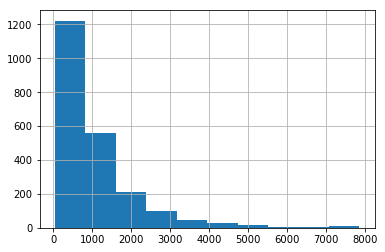

count     2217.000000
mean      1179.438881
std       1420.098309
min         41.000000
25%        490.000000
50%        748.000000
75%       1355.000000
max      20650.000000
dtype: float64

In [4]:
df = pd.Series([sum([len(s) for s in doc]) for doc in docs])

df[df<8000].hist()
plt.show()
df.describe()

# val/test split

In [74]:
from glob import glob, iglob
import random

files = glob('../data/242test/*')
val = random.sample(files, 150)
test = [f for f in files if f not in test]

In [38]:
vstr = ' '.join(val)

In [39]:
tstr = ' '.join(test)

In [40]:
!cp {vstr} ../data/validate/

In [41]:
!cp {tstr} ../data/test/

# make test match

In [3]:
import xml.etree.ElementTree as ET
tree = ET.parse('../answers.xml')
root = tree.getroot()
tbody = root[0][0][1]

In [4]:
def insert(ans, q, p_text, q_prev):
    if q is not None:
        ans[q] = [p_text] if q not in ans else ans[q] + [p_text]
    elif q_prev is not None:
        ans[q_prev] = ans[q_prev] + [p_text]    

In [5]:
ans = {}
q_prev = None
for row in tbody:
    q = row[1][0].text
    ps = row[3]
    for p in ps:
        if not p.text:
            continue
        p_text = p.text.strip(' ,.').replace('\xa0', '')
        ps_list = p_text.split(',')
        for pi in ps_list:
            pi = pi.strip(' ,.')
            insert(ans, q, pi, q_prev)
    if q is not None:
        q_prev = q

In [6]:
len(ans)

228

In [7]:
for k, v in ans.items():
    print(k, v)

2011126928 ['RU 2006113775 А']
2011126929 ['RU 2006113775 A']
2010114200 ['RU 97117509 А']
2006139128 ['RU 2093502 С1']
2010122997 ['RU 2007127531 A']
2010102239 ['RU 2247821 С2', 'RU 2010332 С1']
2009140669 ['RU 61306 U1', 'RU 43892 U1', 'RU 49853 U1', 'SU 385016']
2010120096 ['RU 2333360 C1', 'RU 2309128 С1']
2009111341 ['RU 2242493 C1', 'RU 2242493 C1']
2010138984 ['RU 2291959', 'RU 2258135', 'RU 2244812', 'RU 2093670', 'RU 2168617']
2010133510 ['SU 617412 A']
2010138983 ['RU 2319721 C1']
2008126819 ['SU 1721309 A1', 'SU 170297 A']
2008144634 ['SU 179248 A', 'SU 1682455 A1', 'SU 1142653 A1']
2009148396 ['RU 2003113480 A']
2010132442 ['SU 1827435 A1']
2010152978 ['RU 2322612 C1']
2011109739 ['RU 57390 U1', 'RU 2025609 C1', 'SU 1742515 A']
2009134266 ['RU 2305674 C1', 'RU 2103248 C1']
2009131618 ['RU 2316413 C1', 'SU 1593042 А3']
2010116490 ['SU 1478667 А3', 'SU 258798']
2010110776 ['SU 262684 A', 'RU 2376265 С2', 'RU 2228264 C', '10.05.2004']
2008148713 ['SU 314868 A', 'RU 2251475 C1

# check queries

In [8]:
from glob import glob, iglob
import random

files = glob('../data/242test/*')

In [9]:
valid_queries = {}
for k,v in ans.items():
    found = [fn for fn in files if k in fn]
    if len(found) == 1:
        valid_queries[k] = found[0]

In [10]:
valid_queries

{'2006139128': '../data/242test/_ab_68_2006139128A10010101RU.txt',
 '2007134266': '../data/242test/_ec_66_2007134266A10010101RU.txt',
 '2007138841': '../data/242test/_89_49_2007138841A10010101RU.txt',
 '2007141919': '../data/242test/_f4_09_2007141919A10010101RU.txt',
 '2007147457': '../data/242test/_82_16_2007147457A10010101RU.txt',
 '2007148915': '../data/242test/_05_7a_2007148915A10010101RU.txt',
 '2008101859': '../data/242test/_d3_ed_2008101859A10010101RU.txt',
 '2008103620': '../data/242test/_1b_29_2008103620A10010101RU.txt',
 '2008126819': '../data/242test/_55_d2_2008126819A10010101RU.txt',
 '2008130019': '../data/242test/_f2_58_2008130019A10010101RU.txt',
 '2008130933': '../data/242test/_7c_23_2008130933A10010101RU.txt',
 '2008134147': '../data/242test/_9a_65_2008134147A10010101RU.txt',
 '2008136547': '../data/242test/_b5_aa_2008136547A10010101RU.txt',
 '2008137964': '../data/242test/_3f_58_2008137964A10010101RU.txt',
 '2008140028': '../data/242test/_20_f6_2008140028A10010101RU.t

In [11]:
len(valid_queries)

227

In [12]:
present_queries = {}
for k,v in tqdm(ans.items()):
    found = [fn for fn in all_docs if k in fn]
    present_queries[k] = found

100%|██████████| 228/228 [00:26<00:00,  9.12it/s]


In [13]:
for k,v in present_queries.items():
    print(k,v)

2011126928 ['../data/FIPS/Inventions applications_txt_output/6d/10/2011126928A20130110RU.txt']
2011126929 ['../data/FIPS/Inventions applications_txt_output/dc/fc/2011126929A20130110RU.txt']
2010114200 ['../data/FIPS/Inventions applications_txt_output/71/6b/2010114200A20111020RU.txt']
2006139128 ['../data/FIPS/Inventions applications_txt_output/7e/b4/2006139128A20080520RU.txt']
2010122997 ['../data/FIPS/Inventions applications_txt_output/47/dd/2010122997A20111210RU.txt']
2010102239 ['../data/FIPS/Inventions applications_txt_output/7d/1a/2010102239A20110727RU.txt']
2009140669 ['../data/FIPS/Inventions applications_txt_output/96/81/2009140669A20110510RU.txt']
2010120096 ['../data/FIPS/Inventions applications_txt_output/38/da/2010120096A20111127RU.txt']
2009111341 ['../data/FIPS/Inventions applications_txt_output/bc/48/2009111341A20101110RU.txt']
2010138984 ['../data/FIPS/Inventions applications_txt_output/84/1b/2010138984A20120327RU.txt']
2010133510 ['../data/FIPS/Inventions applications_

In [14]:
len(present_queries)

228

In [15]:
import re
comp = re.compile('[!@#$.,]')

lens = []
for k,v in valid_queries.items():
    text1 = open(v, 'r').read()
    l1 = len(comp.sub('', text1).split())
    if k in present_queries:
        text2 = open(present_queries[k][0], 'r').read()
        l2 = len(comp.sub('', text2).split())
    else:
        l2 = 0
    lens.append([l1,l2])

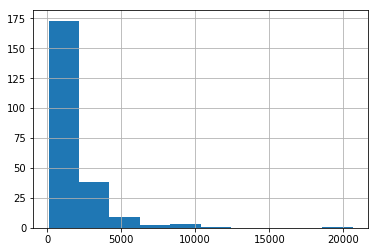

In [16]:
lens = pd.DataFrame(lens, columns=['l1', 'l2'])
dif = lens.l1 - lens.l2
dif.hist()
plt.show()

In [17]:
dif.describe()

count      227.000000
mean      1780.497797
std       2077.649010
min         99.000000
25%        743.500000
50%       1163.000000
75%       2066.500000
max      20641.000000
dtype: float64

In [18]:
q = '2008134147'
print(open(valid_queries[q], 'r').read())

﻿линейный компрессор с опорный втулка из англомерированный материал .
 изобретение относиться к линейный компрессор (1 ) , а также к способ о изготовление , причем линейный компрессор (1 ) содержать корпус (2 ) поршня и поршень (3 ) компрессор , причем поршень (3 ) компрессор двигаться в корпус (2 ) поршня вдоль ось (4 ) возвратно - поступательный , причем поршень (3 ) компрессор опираться в корпус (2 ) поршня с помощь стенка (5 ) корпус , который содержать отверстие (6 ) , и с помощь газ , протекать через отверстие (6 ) , причем стенка (5 ) корпус пористый , в особенность агломерированный , и отличаться высокий надежность в работа .
 фига .2 .
 1 .
 линейный компрессор (1 ) , содержать корпус (2 ) поршня и поршень (3 ) компрессор , выполнять с возможность движение в корпус (2 ) поршня вдоль ось (4 ) возвратно - поступательный , причем поршень (3 ) компрессор опираться в корпус (2 ) поршня с помощь стенка (5 ) корпус , который иметь отверстие (6 ) , и с помощь газ , протекать через отв

In [19]:
print(open(present_queries[q][0], 'r').read())

линейный компрессор с опорный втулка из англомерированный материал  . 
 1 .
 линейный компрессор (1 ) , содержать корпус (2 ) поршня и поршень (3 ) компрессор , выполнять с возможность движение в корпус (2 ) поршня вдоль ось (4 ) возвратно-поступательно , причем поршень (3 ) компрессор опираться в корпус (2 ) поршня с помощь стенка (5 ) корпус , который иметь отверстие (6 ) , и с помощь газ , протекать через отверстие , отличать тем , что стенка (5 ) корпус пористый .
 2 .
 линейный компрессор (1 ) по п.1 , отличать тем , что стенка (5 ) корпус содержать открытый пора .
 3 .
 линейный компрессор (1 ) по п.1 , отличать тем , что стенка (5 ) корпус агломерировать .
 4 .
 линейный компрессор (1 ) по один из пп.1-3 , отличать тем , что локальный сопротивление проход поток через стенка (5 ) корпус изменяться вдоль ось (4 ) .
 5 .
 линейный компрессор (1 ) по п.4 , отличать тем , что пористость стенка (5 ) корпус , в частность доля материал , изменяться вдоль ось (4 ) .
 6 .
 линейный компре

# find patents

In [20]:
# no digits at beginning
max([v[0][0].isdigit() for k, v in ans.items()])

False

In [55]:
class NameStruct():
    def __init__(self, name):
        name = name.replace('С', 'C')
        name = name.replace('А', 'A')
        self.original_name = name
        self.prefix = ''
        self.number = name
        self.postfix = ''
        
        res = re.sub(r'\d{2,}', ' ', name)
        splited = res.split()
        for p in splited:
            self.number = self.number.replace(p, '')
        self.number = self.number.replace(' ', '')
        if len(splited):
            self.prefix = splited[0]
        if len(splited) == 2:
            self.postfix = splited[1]
        
        self.starts_with = self.number + self.postfix
        
    def __repr__(self):
        return '%s %s %s' % (self.prefix, self.number, self.postfix)
            

In [56]:
name = 'RU2254546C1'

S = NameStruct(name)
S

RU 2254546 C1

In [57]:
structed_answers = {}
pat_name_struct = {}
for k, v in ans.items():
    structs = []
    for vi in v:
        struct = NameStruct(vi)
        structs.append(struct)
    structed_answers[k] = structs

In [58]:
for k,v in structed_answers.items():
    print(k,v)

2011126928 [RU 2006113775 A]
2011126929 [RU 2006113775 A]
2010114200 [RU 97117509 A]
2006139128 [RU 2093502 C1]
2010122997 [RU 2007127531 A]
2010102239 [RU 2247821 C2, RU 2010332 C1]
2009140669 [RU 61306 U1, RU 43892 U1, RU 49853 U1, SU 385016 ]
2010120096 [RU 2333360 C1, RU 2309128 C1]
2009111341 [RU 2242493 C1, RU 2242493 C1]
2010138984 [RU 2291959 , RU 2258135 , RU 2244812 , RU 2093670 , RU 2168617 ]
2010133510 [SU 617412 A]
2010138983 [RU 2319721 C1]
2008126819 [SU 1721309 A1, SU 170297 A]
2008144634 [SU 179248 A, SU 1682455 A1, SU 1142653 A1]
2009148396 [RU 2003113480 A]
2010132442 [SU 1827435 A1]
2010152978 [RU 2322612 C1]
2011109739 [RU 57390 U1, RU 2025609 C1, SU 1742515 A]
2009134266 [RU 2305674 C1, RU 2103248 C1]
2009131618 [RU 2316413 C1, SU 1593042 A3]
2010116490 [SU 1478667 A3, SU 258798 ]
2010110776 [SU 262684 A, RU 2376265 C2, RU 2228264 C, . 10052004 .]
2008148713 [SU 314868 A, RU 2251475 C1, SU 1708927 A]
2009110186 [RU 49058 ]
2009110686 [RU 2270304 C1]
2008151996 [RU

In [59]:
def match_file_name(fn, name_struct):
#     fn = fn.lstrip('0')
    if fn.startswith(name_struct.starts_with) \
        and fn.endswith(name_struct.prefix):
            return True
    else: return False
    

In [60]:
pure_paths = [splitext(basename(fn))[0].lstrip('0') for fn in all_docs]

In [61]:
matched_patents = {}
for k,v in tqdm(structed_answers.items()):
    matched = []
    for name_struct in v:
        if name_struct.prefix != 'RU':
            continue
        matched = [fn for fn in pure_paths if match_file_name(fn, name_struct)]
        matched_patents[name_struct.original_name] = matched

100%|██████████| 228/228 [01:46<00:00,  2.14it/s]


In [69]:
matched_patents['RU 772523'] = ['_59_e5_0000772523A119801023SU']

In [48]:
mprog = re.compile('^0{0+')
m = mprog.match('0100111')
m

<_sre.SRE_Match object; span=(0, 1), match='0'>

In [51]:
'000033'.lstrip('0')

'33'

In [46]:
'С1' == 'C1'

False

In [70]:
matched_patents

{'RU 10918 U1': ['10918U119990816RU'],
 'RU 12434': ['12434U120000110RU',
  '124346U120130120RU',
  '124347U120130120RU',
  '124349U120130120RU',
  '124348U120130120RU',
  '124343U120130120RU',
  '124340U120130120RU',
  '124342U120130120RU',
  '124345U120130120RU',
  '124344U120130120RU',
  '124341U120130120RU'],
 'RU 14331 U1': ['14331U120000710RU'],
 'RU 1836037 A3': [],
 'RU 2001109028 A': ['2001109028A20030420RU'],
 'RU 2001112395': ['2001112395A20030510RU'],
 'RU 2001132085 A': ['2001132085A20031010RU'],
 'RU 2003113480 A': ['2003113480A20041110RU'],
 'RU 2004100120 A': ['2004100120A20050620RU'],
 'RU 2004100124 A': ['2004100124A20050620RU'],
 'RU 2004100136 A': ['2004100136A20050620RU'],
 'RU 2004100138 A': ['2004100138A20050620RU'],
 'RU 2004129311A': ['2004129311A20050420RU'],
 'RU 2005100694 A': ['2005100694A20060620RU'],
 'RU 2005130234': ['2005130234A20070420RU'],
 'RU 2005131896 A': ['2005131896A20070427RU'],
 'RU 2005138978 A': ['2005138978A20070620RU'],
 'RU 2005491 C1': 

In [71]:
not_found = {}
for k,v in matched_patents.items():
    if len(v) != 1:
        not_found[k] = v
not_found

{'RU 12434': ['12434U120000110RU',
  '124346U120130120RU',
  '124347U120130120RU',
  '124349U120130120RU',
  '124348U120130120RU',
  '124343U120130120RU',
  '124340U120130120RU',
  '124342U120130120RU',
  '124345U120130120RU',
  '124344U120130120RU',
  '124341U120130120RU'],
 'RU 1836037 A3': [],
 'RU 22056072 C2': [],
 'RU 2217741 C2': [],
 'RU 2219423 C2': [],
 'RU 2219858 C2': [],
 'RU 2234314 C1': [],
 'RU 2300050': ['2300050C120070527RU', '2300050C920070927RU'],
 'RU 2319721 C1': [],
 'RU 2338491 C1': [],
 'RU 2376265 C2': [],
 'RU2007137801/06': []}

In [99]:
not_found_corrected = {'RU 12434': ['12434U120000110RU',
  '124340U120130120RU'],
 'RU 1836037 A3': [],
 'RU 22056072 C2': [],
 'RU 2217741 C2': [],
 'RU 2219423 C2': [],
 'RU 2219858 C2': [],
 'RU 2234314 C1': [],
 'RU 2300050': ['2300050C120070527RU', '2300050C920070927RU'],
 'RU 2319721 C1': [],
 'RU 2338491 C1': [],
 'RU 2376265 C2': [],
 'RU2007137801/06': []}

In [104]:
name_match = {k: [fn for fn in all_docs if v[0] in fn] for k,v in matched_patents.items() if len(v) == 1}

In [105]:
name_match

{'RU 10918 U1': ['../data/FIPS/Utility models patents_txt_output/1994_2013/21/00/0000010918U119990816RU.txt'],
 'RU 14331 U1': ['../data/FIPS/Utility models patents_txt_output/1994_2013/65/0c/0000014331U120000710RU.txt'],
 'RU 2001109028 A': ['../data/FIPS/Inventions applications_txt_output/07/54/2001109028A20030420RU.txt'],
 'RU 2001112395': ['../data/FIPS/Inventions applications_txt_output/cf/02/2001112395A20030510RU.txt'],
 'RU 2001132085 A': ['../data/FIPS/Inventions applications_txt_output/d5/15/2001132085A20031010RU.txt'],
 'RU 2003113480 A': ['../data/FIPS/Inventions applications_txt_output/18/7e/2003113480A20041110RU.txt'],
 'RU 2004100120 A': ['../data/FIPS/Inventions applications_txt_output/68/54/2004100120A20050620RU.txt'],
 'RU 2004100124 A': ['../data/FIPS/Inventions applications_txt_output/dc/56/2004100124A20050620RU.txt'],
 'RU 2004100136 A': ['../data/FIPS/Inventions applications_txt_output/28/30/2004100136A20050620RU.txt'],
 'RU 2004100138 A': ['../data/FIPS/Inventions

In [116]:
full_match = {}
for k,v in structed_answers.items():
    if k not in valid_queries:
        continue
    full_match[valid_queries[k]] = [name_match[s.original_name][0] for s in v if s.original_name in name_match]

In [123]:
full_match = {splitext(basename(k))[0]: [splitext(basename(vi))[0] for vi in v] for k,v in full_match.items() if len(v)}

In [127]:
for k,v in full_match.items():
    print(k,v)

_40_1a_2011126928A10010101RU ['2006113775A20071120RU']
_47_59_2011126929A10010101RU ['2006113775A20071120RU']
_df_5c_2010114200A10010101RU ['0097117509A19990720RU']
_ab_68_2006139128A10010101RU ['0002093502C119971020RU']
_1b_60_2010122997A10010101RU ['2007127531A20090127RU']
_ef_e0_2010102239A10010101RU ['0002247821C220050310RU', '0002010332C119940330RU']
_a5_03_2009140669A10010101RU ['0000061306U120070227RU', '0000043892U120050210RU', '0000049853U120051210RU']
_87_7b_2010120096A10010101RU ['0002333360C120080910RU', '0002309128C120071027RU']
_c3_b8_2009111341A10010101RU ['0002242493C120041220RU', '0002242493C120041220RU']
_ff_96_2010138984A10010101RU ['0002291959C120070120RU', '0002258135C120050810RU', '0002244812C120050120RU', '0002093670C119971020RU', '0002168617C220010610RU']
_fd_f0_2009148396A10010101RU ['2003113480A20041110RU']
_be_ef_2010152978A10010101RU ['0002322612C120080420RU']
_78_bc_2011109739A10010101RU ['0000057390U120061010RU', '0002025609C119941230RU']
_e0_5d_2009134266

In [124]:
len(full_match) 

187

# Возможные варианты

In [74]:
[fn for fn in all_docs if '2376265' in fn]

['../data/FIPS/Inventions patents_txt_output/a7/c2/0002376265C120091220RU.txt']

## Сравним длины запросов и соответствующих порочащих документов

In [91]:
lens1 = []
for k,v in valid_queries.items():
    txt = open(v, 'r').read()
    l = len(comp.sub('', txt).split())
    lens1.append(l)

In [93]:
pd.Series(lens1).describe()

count      227.000000
mean      1978.325991
std       2204.793990
min        245.000000
25%        819.000000
50%       1326.000000
75%       2415.500000
max      21374.000000
dtype: float64

In [87]:
lens2 = []
for k,v in tqdm(matched_patents.items()):
    if len(v) != 1:
        continue
    short_fn = v[0]
    fn = [fn for fn in all_docs if short_fn in fn][0]
    txt = open(fn, 'r').read()
    l = len(comp.sub('', txt).split())
    lens2.append(l)
    


100%|██████████| 288/288 [00:31<00:00,  8.50it/s]


In [98]:
pd.Series(lens2).describe()

count      276.000000
mean      2106.989130
std       3749.723102
min         41.000000
25%        443.750000
50%       1267.000000
75%       2335.000000
max      45541.000000
dtype: float64